In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import math as m
import time 
from numpy.lib.format import open_memmap

# Prerequisites

## The Thomas Algorithm
The thomas algorithm is a more computationally efficient way to solve for the unknowns as compared to matrix inversion (works via LU decomposition).

In [2]:
# Define the tridiagonal matrix solver algorithm for BLACK-SCHOLES EQUATION FORMAT
'''
For Tx = d
Inputs:
    - a = lower triangular vector
    - b = diagonal vector
    - c = upper diagonal vector
    - d = -aV_{i-1}^n + (1 + b)V_i^n - cV_{i+1}^n = constant term of knowns for share prices (i-1, i, i+1) at time n
Output:
    - unew = updated v values over space for time n+1
'''
def TDMA(a,b,c,d):
    n = len(d)
    e = np.zeros(n-1)
    f = np.zeros(n)
    V = np.zeros(n)
    
    e[0] = c[0]/b[0]
    f[0] = d[0]/b[0]
    for i in range(1,n-1):
        e[i] = c[i]/(b[i] - a[i]*e[i-1])
    for i in range(1,n):
        f[i] = (d[i] - a[i]*f[i-1])/(b[i] - a[i]*e[i-1])
    
    V[n-1] = f[n-1]
    for i in range(n-1,0,-1):
        V[i-1] = f[i-1] - e[i-1]*V[i]
    return V

## Call Option  Parameters

In [3]:
### // CALL OPTION PARAMETERS /// ###
sig = 0.15 # volatility (std deviation of log returns)
K = 10 # dollars
T = 2 # years
r = 0.02 # yearly risk free interest rate

## Analytical Solution

In [4]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
import math
#import sympy as sy

def erf(x):
    if isinstance(x, (int, float)):
        erf = m.erf(x)
    else:
        erf = np.array([m.erf(x) for x in x])
        
    return erf


# function for N(x) - normal CDF
def N(x) :
    return 0.5*(erf(x/np.sqrt(2)) + 1)


'''
# function to calculate the analytical solution to the black scholes equation for a european call given parameters
# INPUTS : 
    - S = stock price (vector)
    - t = time
    - sig = volatility 
    - K = strike price 
    - T = expiry time 
    - r = risk free rate 
    - N = Cumulative normal distribution function (defined above)
OUTPUTS : 
    - Analytical solution for European Call
'''
def BS_analytic_point_S(S, t, sig = sig, K = K, T = T, r = r, N = N) :
    # S=0 implies a zero value, S=0 implies the log going to negative infinity and the cumulative distributions having values 0.
    S1=S[0]
    ECall1 = np.array([0])
    
    S2=S[1:]
    
    def d1(S):
        return (np.log(S/K) + (r + 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5)) 

    def d2(S):
        return (np.log(S/K) + (r - 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5))
            
    ECall2 = S2*N(d1(S2)) - K*np.exp(-r*(T-t))*N(d2(S2))
    
    ECall = np.concatenate([ECall1, ECall2])
    
    return ECall

'''
Same as above, now considering transformed Z grid where z = lnS.
'''

def BS_analytic_point_Z(Z, t, sig = sig, K = K, T = T, r = r, N = N) :
    # S=0 implies a zero value, S=0 implies the log going to negative infinity and the cumulative distributions having values 0.
    def d1(Z):
        return (Z - np.log(K) + (r + 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5))
    
    def d2(Z):
        return (Z - np.log(K) + (r - 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5))
    
    ECall = np.where(np.exp(Z) == 0, 0, np.exp(Z)*N(d1(Z)) - K*np.exp(-r*(T-t))*N(d2(Z)))
    
    return ECall


'''
Same as above, now considering transformed Z grid where z = lnS - (r-0.5*sigma^2)*t i.e. the diffusion transformation.
'''
def BS_analytic_point_D(Z, t, sig = sig, K = K, T = T, r = r, N = N) :
    # S=0 implies a zero value, S=0 implies the log going to negative infinity and the cumulative distributions having values 0.
    def d1(Z):
        return (Z + (r - 0.5*sig**2)*t - np.log(K) + (r + 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5))
    
    def d2(Z):
        return (Z + (r - 0.5*sig**2)*t - np.log(K) + (r - 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5)) # r terms cancel in t
            
    ECall = np.where(np.exp(Z + (r - 0.5*sig**2)*t) == 0, 0, np.exp(Z + (r - 0.5*sig**2)*t) * N(d1(Z)) - K * np.exp(-r*(T - t)) * N(d2(Z)))
            
    return ECall


'''
Function to calculate analytic Black-Scholes solution given a grid in share price and values specifying the time grid.
INPUTS:
    - S = 1D array of S grid over time (entries = S grid values)
    - dt = time step
    - nt = total number of timesteps
OUTPUT:
    - 2D array of analytical solution over grid values
'''
# function BSASEC for grid of S and t
def BSa_S(S, dt, nt):
    # empty solution matrix
    Asol = np.zeros((len(S),nt+1))
    
    # Initial Conditions
    VIC = np.maximum(S - K, 0)
    Asol[:,0] = VIC # corresponding to t = T
    
    # Solving backwards in time
    for n in range(1, nt+1):
        Asol[:,n] = BS_analytic_point_S(S=S, t=T - n*dt)
    
    return Asol


def BSa_Z(Z, dt, nt):
    # empty solution matrix
    Asol = np.memmap('R2CNAsol.arr', dtype=np.float64, mode='w+', shape=(len(Z),nt+1)) #np.zeros((len(Z),nt+1))
    
    # Initial Conditions
    VIC = np.maximum(np.exp(Z) - K, 0)
    Asol[:,0] = VIC # corresponding to t = T
    
    # Solving backwards in time
    for n in range(1, nt+1):
        Asol[:,n] = BS_analytic_point_Z(Z=Z, t=T - n*dt)
    
    Asol.flush()
    
    sol = np.memmap('R2CNAsol.arr', dtype=np.float64, mode='r', shape=(len(Z),nt+1)) 
    
    return sol


'''
Function BSASEC for grid of S and t
INPUTS:
    - Z = 1D array of Z grid that, when transformed back to S, moves over time (row = S grid values, column = time) 
          with Z = lnS - (r-0.5*sig^2)*t this implies S = exp[Z + (r-0.5*sig^2)*t]
    - dt = time step
    - nt = total number of timesteps
OUTPUT:
    - 2D array of analytical solution over grid values
'''
def BSa_D(Z, dt, nt):
    # empty solution matrix
    Asol = np.zeros((len(Z),nt+1))
    
    # Initial Conditions
    VIC = np.maximum(np.exp(Z + (r - 0.5*sig**2)*T) - K, 0)
    Asol[:,0] = VIC # corresponding to t = T
    
    # Solving backwards in time
    for n in range(1, nt+1):
        Asol[:,n] = BS_analytic_point_D(Z=Z, t=T - n*dt)
    
    return Asol

## Discretization Error Matrix Calculator

In [5]:
# Define function that, given a numerical solution, will provide the discretization errors
def DErrors_S(Nsol, S, dt, nt):
    # Initialise error matrix
    Derr = np.zeros((len(S),nt+1))
    
    # Calculate analytic solutions for grid
    Asol = BSa_S(S, dt, nt)
    
    # Calculate errors
    Derr = np.subtract(Nsol, Asol)
    return Derr


def DErrors_Z(Nsol, Z, dt, nt):
    # Initialise error matrix
    #numsol = np.memmap('RCNNsol.array', dtype=np.float64, mode='w+', shape=(len(Z), nt+1))
    #numsol = Nsol.copy()
    
    Derr = np.memmap('R2CNDerr.arr', dtype=np.float64, mode='w+', shape=(len(Z), nt+1)) #np.zeros((len(Z),nt+1))
    
    # Calculate analytic solutions for grid
    Asol = BSa_Z(Z, dt, nt)
    
    
    # Calculate errors
    for n in range(nt+1):
        Derr[:,n] = np.subtract(Nsol[:, n], Asol[:,n])
    Derr.flush()
    
    Derr = np.memmap('R2CNDerr.arr', dtype=np.float64, mode='r', shape=(len(Z), nt+1))
    
    return Derr


def DErrors_D(Nsol, Z, dt, nt):
    # Initialise error matrix
    Derr = np.zeros((len(Z),nt+1))
    
    # Calculate analytic solutions for grid
    Asol = BSa_D(Z, dt, nt)
    
    # Calculate errors
    Derr = np.subtract(Nsol, Asol)
    return Derr

# Laasonen method for Crank-Nicolson
Want a function Laasonen which performs one step of the laasonen method on the input matrix (parameterised by im, jm) 

## 1. $(\ln S, t)$
#### Restating the PDE

${\partial V \over \partial t} + {1 \over 2}\sigma^2{\partial^2 V \over \partial z^2} + (r - \frac{1}{2}\sigma^2){\partial V \over \partial z} - rV = 0.$

#### The FDE
$\frac{V_{i}^{n+1} - V_i^n}{\Delta t} + Z_i^{n+1} = 0$
$\Rightarrow V_i^n = V_i^{n+1} + \Delta t Z_i^{n+1}$

which results in the tridiagonal system

$a V_{i-1}^{n+1} + (1-b) V_{i}^{n+1} + c V_{i+1}^{n+1} = V_i^n$

with coefficients:
- $a_i = {\Delta t \over 2}[\frac{\sigma^2}{(\Delta z)^2} - \frac{(r - \frac{1}{2}\sigma^2)}{\Delta z}]$
- $b_i = {\Delta t}[\frac{\sigma^2}{(\Delta z)^2} + r]$
- $c_i = {\Delta t \over 2}[\frac{\sigma^2}{(\Delta z)^2} + \frac{(r - \frac{1}{2}\sigma^2)}{\Delta z}]$

Note that this actually forms an explicit scheme in the backward time problem, as (n) is the unknown and (n+1) the knowns (DO STABILITY ANALYSIS FOR BOTH). Thus, the forward time transformation to $\tau = T-t$ will be implemented.


## 2. $(\ln S, \tau)$

#### The PDE

$-{\partial V \over \partial t} + {1 \over 2}\sigma^2{\partial^2 V \over \partial z^2} + (r - \frac{1}{2}\sigma^2){\partial V \over \partial z} - rV = 0.$

#### The FDE
$-\frac{V_{i}^{n+1/2} - V_i^n}{\Delta t} + Z_i^{n+1/2} = 0$
$\Rightarrow V_i^n = V_i^{n+1/2} - \Delta t Z_i^{n+1/2}$

which flips the signs of the coefficients in the $(\ln S, t)$ tridiagonal system, and results in the tridiagonal system

$-a V_{i-1}^{n+1/2} + (1+b) V_{i}^{n+1/2} - c V_{i+1}^{n+1/2} = V_i^n$


with coefficients:
- $a_i = {\Delta t \over 2}[\frac{\sigma^2}{(\Delta z)^2} - \frac{(r - \frac{1}{2}\sigma^2)}{\Delta z}]$
- $b_i = {\Delta t}[\frac{\sigma^2}{(\Delta z)^2} + r]$
- $c_i = {\Delta t \over 2}[\frac{\sigma^2}{(\Delta z)^2} + \frac{(r - \frac{1}{2}\sigma^2)}{\Delta z}]$

Now, the unknowns are terms in (n+1) and so this forms an implicit scheme with unconditional stability.

## Rannacher Timestepping Function
Currently calculates the first two integer time steps using half-steps of Backwards Euler. Can potentially implement customizable numbers of points to replace, and the factor of stepping in the intermediate steps. 

In [6]:
def RannacherStart(R, dt, nt, dZ, iZ, VIC):
    # define half time step
    hdt = dt/2
    
    VRannacher = np.memmap('R2CNRannacher.arr', dtype=np.float64, mode='w+', shape=(iZ-1, nt+1)) 
    
    Smin = 1e-10 # can no longer use Smin = 0 as log(0) = -inf, use a small number as replacement
    Smax = 5000 # can use even larger Smax as ln transformation squishes results quicker
    Zmin = np.log(Smin) # low boundary
    Zmax = np.log(Smax) # high bonudary
    VB1 = 0
    VB2 = Smax
    
    # Store all 
    Vinit_halfs = np.zeros((iZ-1, 2*R+1))
    Vinit_halfs[:,0] = VIC[1:-1]
    
    # constants in tridiagonal system
    ac = (hdt/2 * (sig**2/dZ**2 - (r - 0.5*sig**2)/dZ))
    bc = (hdt * (sig**2/dZ**2 + r)) # care with 1 +/- b
    cc = (hdt/2 * (sig**2/dZ**2 + (r - 0.5*sig**2)/dZ))

    # vectors of tridiagonal
    a = - ac * np.ones(iZ-1) # lower diag
    b = (1 + bc) * np.ones(iZ-1) # diag has (1 - bc)
    c = - cc * np.ones(iZ-1) # upper diag
    
    # initialise constant vector
    d = np.zeros(iZ-1)
    
    # Solve the tridiagonal system for one half-step using Vinit
    for n in range(1, 2*R+1):
        # Half step
        # i=1: Includes i=0 boundary
        d[0] = Vinit_halfs[0, n-1] + ac*VB1
        
        # i=2,...,iZ-2: no boundary values
        d[1:-1] = Vinit_halfs[1:-1, n-1]
        
        # i=iZ-1: Includes i=iZ boundary
        d[-1] = Vinit_halfs[-1, n-1] + cc*VB2
        
        # Calculate half-step results
        Vinit_halfs[:,n] = TDMA(a, b, c, d)
        
    # Get the two whole steps
    for s in range(1, R+1):
        VRannacher[:, s] = Vinit_halfs[:, 2*s]
    
    VRannacher.flush()

    return np.memmap('R2CNRannacher.arr', dtype=np.float64, mode='r', shape=(iZ-1, nt+1))

## Rannacher Present Value of European Call (2R 1/2 steps)

In [7]:
def PV_Rannacher(dt, dZ, R=2, sig=sig, K=K, r=r, T=T):
    ### SETTING PARAMETERS
    Smin = 1e-10 # can no longer use Smin = 0 as log(0) = -inf, use a small number as replacement
    Smax = 500 # can use even larger Smax as ln transformation squishes results quicker
    Zmin = np.log(Smin) # low boundary
    Zmax = np.log(Smax) # high bonudary
    iZ = round((Zmax-Zmin) / dZ)
    
    dZ = (Zmax-Zmin)/iZ # update to fit grid boundaries

    Z = np.linspace(Zmin, Zmax, iZ + 1) # Nx total grid points from 0 to L included (combine two np.linspace of different step sizes)
    nt = int(round(T/dt)) # number of steps in time
    dt = T/nt
    
    print(f'Stepsizes: dz = {dZ} and dt = {dt}')
    print(f'lambda = {dt/dZ}')

     #----------------------------------------------------------------------------------------
    
    ### INITIAL AND BOUNDARY CONDITIONS
    VIC = np.maximum(np.exp(Z) - K, 0)

    VB1 = 0
    VB2 = Smax

    VIC[0] = VB1 # still use zero as the boundary value
    VIC[-1] = VB2
    
     #----------------------------------------------------------------------------------------
    
    ### SOLVING THE TRIDIAGONAL SYSTEM ---> first two CN steps replaced with 2nd and 4th Laasonen half-steps
    # Define solution matrix
    V = np.memmap('R2CNPVmatrix.arr', dtype=np.float64, mode='w+', shape=(iZ-1, nt+1)) # np.zeros((iZ-1, nt+1))
    # Initialise starting matrix
    Vstart = np.zeros((iZ-1, nt+1))
    # add initial conditions in first column
    Vstart[:,0] = VIC[1:-1]
    
    ## Rannacher timestepping
    VRanStart = RannacherStart(R=R, dt=dt, nt=nt, dZ=dZ, iZ=iZ, VIC=VIC)
    for j in range(nt+1):
        V[:, j] = VRanStart[:,j]
    
    ## Crank-Nicolson
    # Define tridiagonal system
    # constants in system
    ac = (dt/4 * (sig**2/dZ**2 - (r - 0.5*sig**2)/dZ))
    bc = (dt/2 * (sig**2/dZ**2 + r)) # care with 1 +/- b
    cc = (dt/4 * (sig**2/dZ**2 + (r - 0.5*sig**2)/dZ))

    # vectors of tridiagonal
    a = - ac * np.ones(iZ-1) # lower diag
    b = (1 + bc) * np.ones(iZ-1) # diag has (1 - bc)
    c = - cc * np.ones(iZ-1) # upper diag

    # check diagonal dominance for thomas algorithm stability
    print('\n Tridiagonal system coefficients:')
    print(f'lower diag values = {-ac}')
    print(f'diag values = {1 + bc}')
    print(f'upper diag values = {-cc}')


    # empty RHS vector
    d = np.zeros(iZ-1)


    # iterate over time, excluding first two timesteps solved with Rannacher timestepping
    for j in range(R+1, nt+1):
        # left boundary
        d[0] = (ac*VB1 + (1 - bc)*V[0,j-1] + cc*V[1,j-1]) + ac*VB1
        # no boundaries involved
        d[1:-1] = (ac*V[0:-2,j-1] + (1 - bc)*V[1:-1,j-1] + cc*V[2:,j-1])
        # right boundary
        d[-1] = (ac*V[-2,j-1] + (1 - bc)*V[-1,j-1] + cc*VB2) + cc*VB2 #problematic
    
        # store solution
        V[:,j] = TDMA(a,b,c,d)
    
    V.flush()
    
    V = np.memmap('R2CNPVmatrix.arr', dtype=np.float64, mode='r', shape=(iZ-1, nt+1)) 
    

    # Matrix of results
    # Add the i=0 and i=nS boundary condition values

    Vsol = np.zeros((iZ+1,nt+1))
    V0 = np.array([VB1])
    ViZ = np.array([VB2])
    
    for j in range(nt+1):
        Vsol[:,j] = np.concatenate((V0, V[:,j], ViZ), axis=0)
    
    #----------------------------------------------------------------------------------------
    ### // CALCULATING MAX ERROR //
    
    # Errors
    # max
    Error = DErrors_Z(Vsol, Z, dt=dt, nt=nt)
    # abs max
    Aerror = np.abs(Error)
    
    # Absolute final error values
    AFE = Aerror[:,-1]

    
    ###  CONSIDERING THE ENTIRE S DOMAIN 
    # MAX ERROR
    ME = np.max(AFE)
    print('\n ENTIRE S DOMAIN ERRORS')
    print(f'1. Maximal error: {ME} \n')
    ME_ind = np.where(AFE == ME)[0][0]
    print(f'located at {ME_ind}, z value of {Zmin + ME_ind*dZ}, S value of {np.exp(Zmin + ME_ind*dZ)} \n')


    # Absolute error sum across S grid at present time
    AES = np.sum(AFE)
    print(f'2. Absolute sum of errors: {AES}')

    
    ###  CONSIDERING A REALISTIC S DOMAIN FROM 0-1000
    # Define a cutoff at a large enough S and corresponding Z
    Scut = 100
    Zcut = np.log(Scut)
    cutoff = int((Zcut - Zmin) / dZ)

    R_AFE = AFE[:cutoff]

    R_ME = np.max(R_AFE)
    print('\n REALISTIC S DOMAIN ERRORS')
    print(f'1. Maximal error: {R_ME} \n')

    R_ME_ind = np.where(R_AFE == R_ME)[0][0]
    print(f'located at {R_ME_ind}, z value of {Zmin + R_ME_ind*dZ}, S value of {np.exp(Zmin + R_ME_ind*dZ)} \n')


    # Absolute error for each time
    R_AES = np.sum(R_AFE)
    print(f'2. Absolute sum of errors: {R_AES}')
    
    return ME, R_ME, Vsol[:,-1] #max error, real max error, present value

# Results

### 2. $\lambda = \frac{\Delta t}{\Delta z} = 10$

In [8]:
# Empty list to store max error values
L2_max_errors = []
L2_real_max_errors = []
# Empty list to store dt and dz's
L2_dt_vals = []
L2_dz_vals = []


#### 2.1 Parameters $\Delta z = 0.1, \Delta t = 1$

In [9]:
dZ=0.1
dt=1

In [10]:
L2P1 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.10013855831631045 and dt = 1.0
lambda = 9.98616334021179

 Tridiagonal system coefficients:
lower diag values = -0.539099720391105
diag values = 2.1318889053956367
upper diag values = -0.5827891850045315

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 2793.6393849231463 

located at 291, z value of 6.114469540105883, S value of 452.3560269860505 

2. Absolute sum of errors: 5676.824107378977

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.04759797718675518 

located at 253, z value of 2.309204324086089, S value of 10.066411866183358 

2. Absolute sum of errors: 0.19674469651417692


In [11]:
L2_max_errors.append(L2P1[0])
L2_real_max_errors.append(L2P1[1])
L2_dt_vals.append(dt)
L2_dz_vals.append(dZ)

#### 2.2 Parameters $\Delta z = 0.05, \Delta t = 0.5$

In [12]:
dZ=0.05
dt=0.5

In [13]:
L2P2 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.049983690646773764 and dt = 0.5
lambda = 10.003262934972428

 Tridiagonal system coefficients:
lower diag values = -1.103852142474421
diag values = 3.2564685602893464
upper diag values = -1.1476164178149255

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 763.0201420568952 

located at 581, z value of 6.0146733358350986, S value of 409.39208334822206 

2. Absolute sum of errors: 4663.550952392508

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.006733510239675056 

located at 507, z value of 2.3158802279738424, S value of 10.133839082682153 

2. Absolute sum of errors: 0.08315581192740563


In [14]:
L2_max_errors.append(L2P2[0])
L2_real_max_errors.append(L2P2[1])
L2_dt_vals.append(dt)
L2_dz_vals.append(dZ)

#### 2.3 Parameters $\Delta z = 0.025, \Delta t = 0.25$

In [15]:
dZ = 0.025
dt = 0.25

In [16]:
L2P3 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.024991845323386882 and dt = 0.25
lambda = 10.003262934972428

 Tridiagonal system coefficients:
lower diag values = -2.2295864226190942
diag values = 5.505437120578693
upper diag values = -2.2733506979595988

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 317.4628274681995 

located at 1162, z value of 6.0146733358350986, S value of 409.39208334822206 

2. Absolute sum of errors: 4386.944740267585

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0013154598707083576 

located at 1015, z value of 2.340872073297227, S value of 10.3902937106048 

2. Absolute sum of errors: 0.038687229133859205


In [17]:
L2_max_errors.append(L2P3[0])
L2_real_max_errors.append(L2P3[1])
L2_dt_vals.append(dt)
L2_dz_vals.append(dZ)

#### 2.4 Parameters $\Delta z = 0.01, \Delta t = 0.1$

In [18]:
dZ=0.01
dt=0.1

In [19]:
L2P4 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.010000156986444134 and dt = 0.1
lambda = 9.999843016020302

 Tridiagonal system coefficients:
lower diag values = -5.602948737811518
diag values = 12.250646788818125
upper diag values = -5.646698051006607

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 121.21013077030995 

located at 2903, z value of 6.004604801706865, S value of 405.2907868545423 

2. Absolute sum of errors: 4435.737272145938

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0002909141155860162 

located at 2535, z value of 2.324547030695424, S value of 10.222048762627221 

2. Absolute sum of errors: 0.017296427220881108


In [20]:
L2_max_errors.append(L2P4[0])
L2_real_max_errors.append(L2P4[1])
L2_dt_vals.append(dt)
L2_dz_vals.append(dZ)

#### 2.5 Parameters: $\Delta z = 0.005, \Delta t = 0.05$

In [21]:
dZ=0.005
dt=0.05

In [22]:
L2P5 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.005000078493222067 and dt = 0.05
lambda = 9.999843016020302

 Tridiagonal system coefficients:
lower diag values = -11.22777213222058
diag values = 23.49979357763625
upper diag values = -11.27152144541567

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 94.40746615920546 

located at 5847, z value of 6.209608019928968, S value of 497.50620054547414 

2. Absolute sum of errors: 4573.036564385731

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 5.4770272817306065e-05 

located at 5072, z value of 2.334547187681867, S value of 10.324783681485076 

2. Absolute sum of errors: 0.007854730330163567


In [23]:
L2_max_errors.append(L2P5[0])
L2_real_max_errors.append(L2P5[1])
L2_dt_vals.append(dt)
L2_dz_vals.append(dZ)

#### 2.6 Parameters: $\Delta z = 0.0025, \Delta t = 0.025$

In [24]:
dZ=0.0025
dt=0.025

In [25]:
L2P6 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.0025000392466110336 and dt = 0.025
lambda = 9.999843016020302

 Tridiagonal system coefficients:
lower diag values = -22.477418921038705
diag values = 45.9988371552725
upper diag values = -22.521168234233794

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 87.4714073198761 

located at 11695, z value of 6.212108059175581, S value of 498.75154162442186 

2. Absolute sum of errors: 4893.069205861541

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 1.750980222414711e-05 

located at 10141, z value of 2.327047069942033, S value of 10.247636257257701 

2. Absolute sum of errors: 0.004255050567783563


In [26]:
L2_max_errors.append(L2P6[0])
L2_real_max_errors.append(L2P6[1])
L2_dt_vals.append(dt)
L2_dz_vals.append(dZ)

#### 2.7 Parameters: $\Delta z = 0.001, \Delta t = 0.01$

In [27]:
dZ=0.001
dt=0.01

In [28]:
L2P7 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.0010000156986444135 and dt = 0.01
lambda = 9.9998430160203

 Tridiagonal system coefficients:
lower diag values = -56.22635928749307
diag values = 113.49656788818123
upper diag values = -56.27010860068816

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 83.98716628119291 

located at 29239, z value of 6.21360808272355, S value of 499.5002420752119 

2. Absolute sum of errors: 5905.247189634037

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 3.974729220423967e-06 

located at 25347, z value of 2.321546983599493, S value of 10.191428089619226 

2. Absolute sum of errors: 0.0020363081120903805


In [29]:
L2_max_errors.append(L2P7[0])
L2_real_max_errors.append(L2P7[1])
L2_dt_vals.append(dt)
L2_dz_vals.append(dZ)

#### Additional steps 

In [30]:
# Empty list to store max error values
L2a_max_errors = []
L2a_real_max_errors = []
# Empty list to store dt and dz's
L2a_dt_vals = []
L2a_dz_vals = []

In [31]:
# dZ = 0.075
# dt = 0.075*10

# L2a1 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L2a_max_errors.append(L2a1[0])
# L2a_real_max_errors.append(L2a1[1])
# L2a_dt_vals.append(dt)
# L2a_dz_vals.append(dZ)

# ###########

# dZ = 0.0375
# dt = 0.0375*10

# L2a2 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L2a_max_errors.append(L2a2[0])
# L2a_real_max_errors.append(L2a2[1])
# L2a_dt_vals.append(dt)
# L2a_dz_vals.append(dZ)

# ###########

# dZ = 0.0175
# dt = 0.0175*10

# L2a3 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L2a_max_errors.append(L2a3[0])
# L2a_real_max_errors.append(L2a3[1])
# L2a_dt_vals.append(dt)
# L2a_dz_vals.append(dZ)

# ###########

# dZ = 0.0075
# dt = 0.0075*10

# L2a4 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L2a_max_errors.append(L2a4[0])
# L2a_real_max_errors.append(L2a4[1])
# L2a_dt_vals.append(dt)
# L2a_dz_vals.append(dZ)

# ###########

# dZ = 0.00375
# dt = 0.00375*10

# L2a5 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L2a_max_errors.append(L2a5[0])
# L2a_real_max_errors.append(L2a5[1])
# L2a_dt_vals.append(dt)
# L2a_dz_vals.append(dZ)

# ###########

# dZ = 0.00175
# dt = 0.00175*10

# L2a6 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L2a_max_errors.append(L2a6[0])
# L2a_real_max_errors.append(L2a6[1])
# L2a_dt_vals.append(dt)
# L2a_dz_vals.append(dZ)

# ###########

# dZ = 0.00075
# dt = 0.00075*10

# L2a7 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L2a_max_errors.append(L2a7[0])
# L2a_real_max_errors.append(L2a7[1])
# L2a_dt_vals.append(dt)
# L2a_dz_vals.append(dZ)

# ###########

# dZ = 0.0005
# dt = 0.0005*10

# L2a8 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L2a_max_errors.append(L2a8[0])
# L2a_real_max_errors.append(L2a8[1])
# L2a_dt_vals.append(dt)
# L2a_dz_vals.append(dZ)

# ###########

# dZ = 0.00025
# dt = 0.00025*10

# L2a9 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L2a_max_errors.append(L2a9[0])
# L2a_real_max_errors.append(L2a9[1])
# L2a_dt_vals.append(dt)
# L2a_dz_vals.append(dZ)

#### PLOTS of Convergence for decreasing step size

In [32]:
# delta t values
dt_vals = np.array(L2_dt_vals + L2a_dt_vals)
sorted_indices = np.argsort(dt_vals)
dt_vals = np.array([dt_vals[i] for i in sorted_indices])
inv_dt_vals = np.divide(np.ones(len(dt_vals)), dt_vals)

# delta z values
dz_vals = np.array(L2_dz_vals + L2a_dz_vals)
dz_vals = np.array([dz_vals[i] for i in sorted_indices])
inv_dz_vals = np.divide(np.ones(len(dz_vals)), dz_vals)


# max errors in realistic range
real_max_errors = np.array(L2_real_max_errors + L2a_real_max_errors)
real_max_errors = np.array([real_max_errors[i] for i in sorted_indices])

# max errors in entire range
max_errors = np.array(L2_max_errors + L2a_max_errors)
max_errors = np.array([max_errors[i] for i in sorted_indices])

##### Realistic S domain for 1/dz

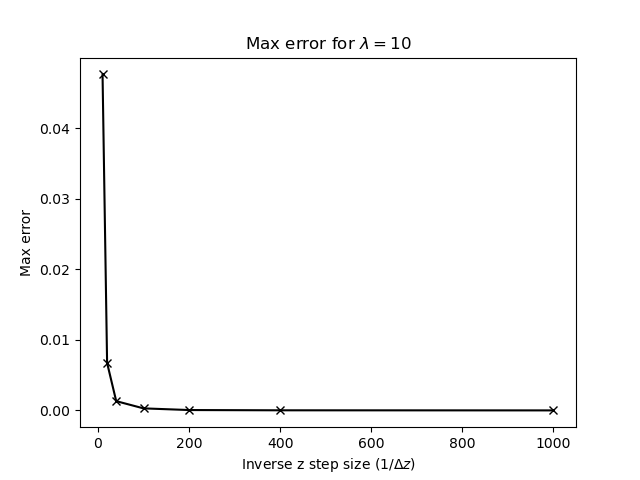

In [33]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 10$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.plot(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

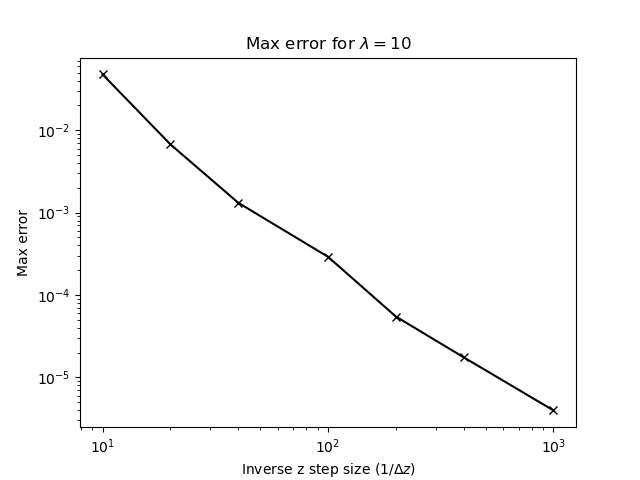

In [34]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 10$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.loglog(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

### 3. $\lambda = \frac{\Delta t}{\Delta z} = 5$

In [35]:
# Empty list to store max error values
L3_max_errors = []
L3_real_max_errors = []
# Empty list to store dt and dz's
L3_dt_vals = []
L3_dz_vals = []


#### 3.1 Parameters $\Delta z = 0.1, \Delta t = 0.5$

In [36]:
dZ=0.1
dt=0.5

In [37]:
L3P1 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.10013855831631045 and dt = 0.5
lambda = 4.993081670105895

 Tridiagonal system coefficients:
lower diag values = -0.2695498601955525
diag values = 1.5659444526978183
upper diag values = -0.29139459250226574

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 706.0932059170327 

located at 290, z value of 6.014330981789573, S value of 409.2519503012083 

2. Absolute sum of errors: 2216.3173214104986

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.02306043594639129 

located at 253, z value of 2.309204324086089, S value of 10.066411866183358 

2. Absolute sum of errors: 0.12388849559847828


In [38]:
L3_max_errors.append(L3P1[0])
L3_real_max_errors.append(L3P1[1])
L3_dt_vals.append(dt)
L3_dz_vals.append(dZ)

#### 3.2 Parameters $\Delta z = 0.05, \Delta t = 0.25$

In [39]:
dZ=0.05
dt=0.25

In [40]:
L3P2 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.049983690646773764 and dt = 0.25
lambda = 5.001631467486214

 Tridiagonal system coefficients:
lower diag values = -0.5519260712372105
diag values = 2.128234280144673
upper diag values = -0.5738082089074628

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 316.7347143181697 

located at 581, z value of 6.0146733358350986, S value of 409.39208334822206 

2. Absolute sum of errors: 2156.695430716851

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0024509242207393367 

located at 507, z value of 2.3158802279738424, S value of 10.133839082682153 

2. Absolute sum of errors: 0.04770446864283547


In [41]:
L3_max_errors.append(L3P2[0])
L3_real_max_errors.append(L3P2[1])
L3_dt_vals.append(dt)
L3_dz_vals.append(dZ)

#### 3.3 Parameters $\Delta z = 0.025, \Delta t = 0.125$

In [42]:
dZ = 0.025
dt = 0.125

In [43]:
L3P3 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.024991845323386882 and dt = 0.125
lambda = 5.001631467486214

 Tridiagonal system coefficients:
lower diag values = -1.1147932113095471
diag values = 3.2527185602893467
upper diag values = -1.1366753489797994

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 151.6715894161257 

located at 1162, z value of 6.0146733358350986, S value of 409.39208334822206 

2. Absolute sum of errors: 2145.3700560652337

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0006769841102565594 

located at 1000, z value of 1.965994393446426, S value of 7.142011029214633 

2. Absolute sum of errors: 0.02303879652813878


In [44]:
L3_max_errors.append(L3P3[0])
L3_real_max_errors.append(L3P3[1])
L3_dt_vals.append(dt)
L3_dz_vals.append(dZ)

#### 3.4 Parameters $\Delta z = 0.01, \Delta t = 0.05$

In [45]:
dZ=0.01
dt=0.05

In [46]:
L3P4 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.010000156986444134 and dt = 0.05
lambda = 4.999921508010151

 Tridiagonal system coefficients:
lower diag values = -2.801474368905759
diag values = 6.625323394409063
upper diag values = -2.8233490255033034

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 61.055800727178564 

located at 2903, z value of 6.004604801706865, S value of 405.2907868545423 

2. Absolute sum of errors: 2219.5168679137632

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.00012937901663412354 

located at 2535, z value of 2.324547030695424, S value of 10.222048762627221 

2. Absolute sum of errors: 0.010277477365696229


In [47]:
L3_max_errors.append(L3P4[0])
L3_real_max_errors.append(L3P4[1])
L3_dt_vals.append(dt)
L3_dz_vals.append(dZ)

#### 3.5 Parameters: $\Delta z = 0.005, \Delta t = 0.025$

In [48]:
dZ=0.005
dt=0.025

In [49]:
L3P5 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.005000078493222067 and dt = 0.025
lambda = 4.999921508010151

 Tridiagonal system coefficients:
lower diag values = -5.61388606611029
diag values = 12.249896788818125
upper diag values = -5.635760722707835

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 31.95745140112649 

located at 5808, z value of 6.014604958693308, S value of 409.364091244712 

2. Absolute sum of errors: 2381.4022907182557

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 2.6432364340647774e-05 

located at 4999, z value of 1.9695414576766552, S value of 7.167389183431509 

2. Absolute sum of errors: 0.0046664567774710565


In [50]:
L3_max_errors.append(L3P5[0])
L3_real_max_errors.append(L3P5[1])
L3_dt_vals.append(dt)
L3_dz_vals.append(dZ)

#### 3.6 Parameters: $\Delta z = 0.0025, \Delta t = 0.0125$

In [51]:
dZ=0.0025
dt=0.0125

In [52]:
L3P6 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.0025000392466110336 and dt = 0.0125
lambda = 4.999921508010151

 Tridiagonal system coefficients:
lower diag values = -11.238709460519352
diag values = 23.49941857763625
upper diag values = -11.260584117116897

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 17.79515381951086 

located at 11623, z value of 6.0321052334195855, S value of 416.5911284277868 

2. Absolute sum of errors: 2719.154005405466

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 7.424344233619706e-06 

located at 10140, z value of 2.324547030695424, S value of 10.222048762627221 

2. Absolute sum of errors: 0.002514443423617626


In [53]:
L3_max_errors.append(L3P6[0])
L3_real_max_errors.append(L3P6[1])
L3_dt_vals.append(dt)
L3_dz_vals.append(dZ)

#### 3.7 Parameters: $\Delta z = 0.001, \Delta t = 0.005$

In [54]:
dZ=0.001
dt=0.005

In [55]:
L3P7 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.0010000156986444135 and dt = 0.005
lambda = 4.99992150801015

 Tridiagonal system coefficients:
lower diag values = -28.113179643746534
diag values = 57.248283944090616
upper diag values = -28.13505430034408

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 10.139680777293506 

located at 29142, z value of 6.116606559955041, S value of 453.3237544527193 

2. Absolute sum of errors: 3743.6062413546065

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 2.366212003890311e-06 

located at 25340, z value of 2.3145468737089807, S value of 10.120336089259277 

2. Absolute sum of errors: 0.0013453608859455908


In [56]:
L3_max_errors.append(L3P7[0])
L3_real_max_errors.append(L3P7[1])
L3_dt_vals.append(dt)
L3_dz_vals.append(dZ)

#### Additional steps 

In [57]:
# Empty list to store max error values
L3a_max_errors = []
L3a_real_max_errors = []
# Empty list to store dt and dz's
L3a_dt_vals = []
L3a_dz_vals = []

In [58]:
# dZ = 0.075
# dt = 0.075*5

# L3a1 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L3a_max_errors.append(L3a1[0])
# L3a_real_max_errors.append(L3a1[1])
# L3a_dt_vals.append(dt)
# L3a_dz_vals.append(dZ)

# ###########

# dZ = 0.0375
# dt = 0.0375*5

# L3a2 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L3a_max_errors.append(L3a2[0])
# L3a_real_max_errors.append(L3a2[1])
# L3a_dt_vals.append(dt)
# L3a_dz_vals.append(dZ)

# ###########

# dZ = 0.0175
# dt = 0.0175*5

# L3a3 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L3a_max_errors.append(L3a3[0])
# L3a_real_max_errors.append(L3a3[1])
# L3a_dt_vals.append(dt)
# L3a_dz_vals.append(dZ)

# ###########

# dZ = 0.0075
# dt = 0.0075*5

# L3a4 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L3a_max_errors.append(L3a4[0])
# L3a_real_max_errors.append(L3a4[1])
# L3a_dt_vals.append(dt)
# L3a_dz_vals.append(dZ)

# ###########

# dZ = 0.00375
# dt = 0.00375*5

# L3a5 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L3a_max_errors.append(L3a5[0])
# L3a_real_max_errors.append(L3a5[1])
# L3a_dt_vals.append(dt)
# L3a_dz_vals.append(dZ)

# ###########

# dZ = 0.00175
# dt = 0.00175*5

# L3a6 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L3a_max_errors.append(L3a6[0])
# L3a_real_max_errors.append(L3a6[1])
# L3a_dt_vals.append(dt)
# L3a_dz_vals.append(dZ)

# ###########

# dZ = 0.00075
# dt = 0.00075*5

# L3a7 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L3a_max_errors.append(L3a7[0])
# L3a_real_max_errors.append(L3a7[1])
# L3a_dt_vals.append(dt)
# L3a_dz_vals.append(dZ)

# ###########

# dZ = 0.0005
# dt = 0.0005*5

# L3a8 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L3a_max_errors.append(L3a8[0])
# L3a_real_max_errors.append(L3a8[1])
# L3a_dt_vals.append(dt)
# L3a_dz_vals.append(dZ)

# ###########

# dZ = 0.00025
# dt = 0.00025*5

# L3a9 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L3a_max_errors.append(L3a9[0])
# L3a_real_max_errors.append(L3a9[1])
# L3a_dt_vals.append(dt)
# L3a_dz_vals.append(dZ)

#### PLOTS of Convergence for decreasing step size

In [59]:
# delta t values
dt_vals = np.array(L3_dt_vals + L3a_dt_vals)
sorted_indices = np.argsort(dt_vals)
dt_vals = np.array([dt_vals[i] for i in sorted_indices])
inv_dt_vals = np.divide(np.ones(len(dt_vals)), dt_vals)

# delta z values
dz_vals = np.array(L3_dz_vals + L3a_dz_vals)
dz_vals = np.array([dz_vals[i] for i in sorted_indices])
inv_dz_vals = np.divide(np.ones(len(dz_vals)), dz_vals)


# max errors in realistic range
real_max_errors = np.array(L3_real_max_errors + L3a_real_max_errors)
real_max_errors = np.array([real_max_errors[i] for i in sorted_indices])

# max errors in entire range
max_errors = np.array(L3_max_errors + L3a_max_errors)
max_errors = np.array([max_errors[i] for i in sorted_indices])

##### Realistic S domain for 1/dz

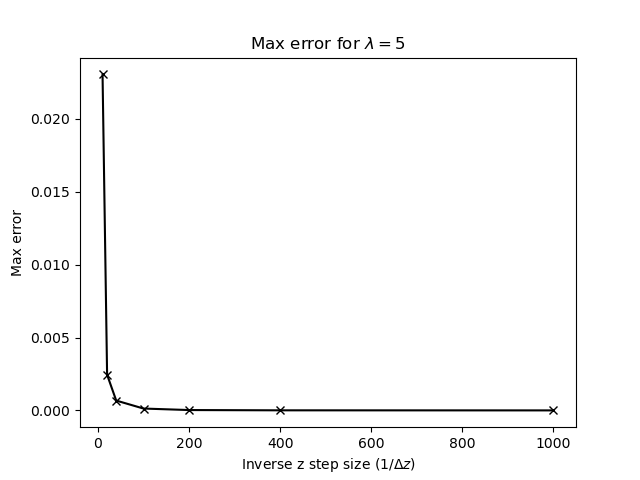

In [60]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 5$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.plot(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

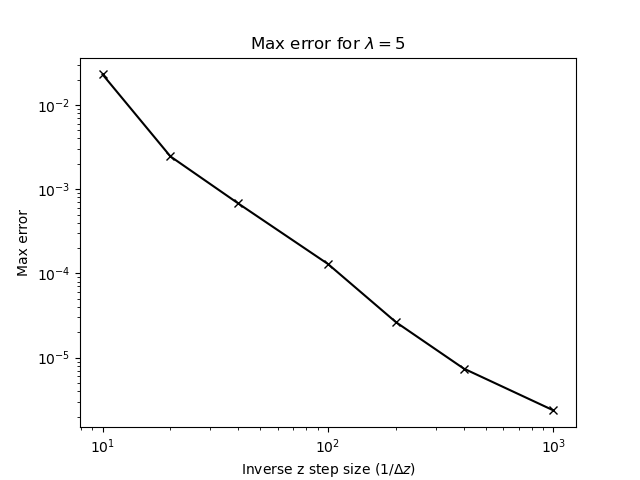

In [61]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 5$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.loglog(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

### 4. $\lambda = \frac{\Delta t}{\Delta z} = 4$

In [62]:
# Empty list to store max error values
L4_max_errors = []
L4_real_max_errors = []
# Empty list to store dt and dz's
L4_dt_vals = []
L4_dz_vals = []


#### 4.1 Parameters $\Delta z = 0.1, \Delta t = 0.4$

In [63]:
dZ=0.1
dt=0.4

In [64]:
L4P1 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.10013855831631045 and dt = 0.4
lambda = 3.9944653360847164

 Tridiagonal system coefficients:
lower diag values = -0.215639888156442
diag values = 1.4527555621582546
upper diag values = -0.2331156740018126

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 533.6063235254364 

located at 290, z value of 6.014330981789573, S value of 409.2519503012083 

2. Absolute sum of errors: 1732.7694314134635

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.02091706166572216 

located at 253, z value of 2.309204324086089, S value of 10.066411866183358 

2. Absolute sum of errors: 0.1159080871438384


In [65]:
L4_max_errors.append(L4P1[0])
L4_real_max_errors.append(L4P1[1])
L4_dt_vals.append(dt)
L4_dz_vals.append(dZ)

#### 4.2 Parameters $\Delta z = 0.05, \Delta t = 0.2$

In [66]:
dZ=0.05
dt=0.2

In [67]:
L4P2 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.049983690646773764 and dt = 0.2
lambda = 4.001305173988971

 Tridiagonal system coefficients:
lower diag values = -0.4415408569897684
diag values = 1.9025874241157386
upper diag values = -0.45904656712597025

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 248.16228722821108 

located at 581, z value of 6.0146733358350986, S value of 409.39208334822206 

2. Absolute sum of errors: 1714.550331651422

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0021210797674963977 

located at 500, z value of 1.965994393446426, S value of 7.142011029214633 

2. Absolute sum of errors: 0.04399647632681066


In [68]:
L4_max_errors.append(L4P2[0])
L4_real_max_errors.append(L4P2[1])
L4_dt_vals.append(dt)
L4_dz_vals.append(dZ)

#### 4.3 Parameters $\Delta z = 0.025, \Delta t = 0.1$

In [69]:
dZ = 0.025
dt = 0.1

In [70]:
L4P3 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.024991845323386882 and dt = 0.1
lambda = 4.001305173988971

 Tridiagonal system coefficients:
lower diag values = -0.8918345690476377
diag values = 2.8021748482314774
upper diag values = -0.9093402791838395

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 120.71937058042101 

located at 1162, z value of 6.0146733358350986, S value of 409.39208334822206 

2. Absolute sum of errors: 1722.596449905736

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0006111423841819036 

located at 1001, z value of 1.9909862387698105, S value of 7.322752184286526 

2. Absolute sum of errors: 0.021867124877969154


In [71]:
L4_max_errors.append(L4P3[0])
L4_real_max_errors.append(L4P3[1])
L4_dt_vals.append(dt)
L4_dz_vals.append(dZ)

#### 4.4 Parameters $\Delta z = 0.01, \Delta t = 0.04$

In [72]:
dZ=0.01
dt=0.04

In [73]:
L4P4 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.010000156986444134 and dt = 0.04
lambda = 3.9999372064081204

 Tridiagonal system coefficients:
lower diag values = -2.2411794951246073
diag values = 5.50025871552725
upper diag values = -2.2586792204026427

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 49.32641017957104 

located at 2903, z value of 6.004604801706865, S value of 405.2907868545423 

2. Absolute sum of errors: 1807.6838225273398

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.00011001245623987188 

located at 2535, z value of 2.324547030695424, S value of 10.222048762627221 

2. Absolute sum of errors: 0.009514817964707309


In [74]:
L4_max_errors.append(L4P4[0])
L4_real_max_errors.append(L4P4[1])
L4_dt_vals.append(dt)
L4_dz_vals.append(dZ)

#### 4.5 Parameters: $\Delta z = 0.005, \Delta t = 0.02$

In [75]:
dZ=0.005
dt=0.02

In [76]:
L4P5 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.005000078493222067 and dt = 0.02
lambda = 3.9999372064081204

 Tridiagonal system coefficients:
lower diag values = -4.491108852888232
diag values = 9.999917431054499
upper diag values = -4.5086085781662675

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 26.238310428412774 

located at 5809, z value of 6.01960503718653, S value of 411.41606958453735 

2. Absolute sum of errors: 1973.0272437452818

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 2.3724081944204167e-05 

located at 5001, z value of 1.979541614663102, S value of 7.239423778773581 

2. Absolute sum of errors: 0.004397753290498354


In [77]:
L4_max_errors.append(L4P5[0])
L4_real_max_errors.append(L4P5[1])
L4_dt_vals.append(dt)
L4_dz_vals.append(dZ)

#### 4.6 Parameters: $\Delta z = 0.0025, \Delta t = 0.01$

In [78]:
dZ=0.0025
dt=0.01

In [79]:
L4P6 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.0025000392466110336 and dt = 0.01
lambda = 3.9999372064081204

 Tridiagonal system coefficients:
lower diag values = -8.990967568415483
diag values = 18.999534862108998
upper diag values = -9.008467293693517

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 15.058526695820262 

located at 11628, z value of 6.044605429652641, S value of 421.83128252620736 

2. Absolute sum of errors: 2312.481504623382

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 6.214773080381875e-06 

located at 10140, z value of 2.324547030695424, S value of 10.222048762627221 

2. Absolute sum of errors: 0.002326942042810298


In [80]:
L4_max_errors.append(L4P6[0])
L4_real_max_errors.append(L4P6[1])
L4_dt_vals.append(dt)
L4_dz_vals.append(dZ)

#### 4.7 Parameters: $\Delta z = 0.001, \Delta t = 0.004$

In [81]:
dZ=0.001
dt=0.004

In [82]:
L4P7 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.0010000156986444135 and dt = 0.004
lambda = 3.9999372064081204

 Tridiagonal system coefficients:
lower diag values = -22.490543714997226
diag values = 45.998627155272494
upper diag values = -22.508043440275266

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.609193795136946 

located at 29237, z value of 6.211608051326262, S value of 498.5022242742604 

2. Absolute sum of errors: 3337.9469585357006

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 2.173829111828951e-06 

located at 25338, z value of 2.3125468423116935, S value of 10.100115327149673 

2. Absolute sum of errors: 0.0012715233694759116


In [83]:
L4_max_errors.append(L4P7[0])
L4_real_max_errors.append(L4P7[1])
L4_dt_vals.append(dt)
L4_dz_vals.append(dZ)

#### Additional steps 

In [84]:
# Empty list to store max error values
L4a_max_errors = []
L4a_real_max_errors = []
# Empty list to store dt and dz's
L4a_dt_vals = []
L4a_dz_vals = []

In [85]:
# dZ = 0.075
# dt = 0.075*4

# L4a1 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L4a_max_errors.append(L4a1[0])
# L4a_real_max_errors.append(L4a1[1])
# L4a_dt_vals.append(dt)
# L4a_dz_vals.append(dZ)

# ###########

# dZ = 0.0375
# dt = 0.0375*4

# L4a2 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L4a_max_errors.append(L4a2[0])
# L4a_real_max_errors.append(L4a2[1])
# L4a_dt_vals.append(dt)
# L4a_dz_vals.append(dZ)

# ###########

# dZ = 0.0175
# dt = 0.0175*4

# L4a3 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L4a_max_errors.append(L4a3[0])
# L4a_real_max_errors.append(L4a3[1])
# L4a_dt_vals.append(dt)
# L4a_dz_vals.append(dZ)

# ###########

# dZ = 0.0075
# dt = 0.0075*4

# L4a4 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L4a_max_errors.append(L4a4[0])
# L4a_real_max_errors.append(L4a4[1])
# L4a_dt_vals.append(dt)
# L4a_dz_vals.append(dZ)

# ###########

# dZ = 0.00375
# dt = 0.00375*4

# L4a5 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L4a_max_errors.append(L4a5[0])
# L4a_real_max_errors.append(L4a5[1])
# L4a_dt_vals.append(dt)
# L4a_dz_vals.append(dZ)

# ###########

# dZ = 0.00175
# dt = 0.00175*4

# L4a6 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L4a_max_errors.append(L4a6[0])
# L4a_real_max_errors.append(L4a6[1])
# L4a_dt_vals.append(dt)
# L4a_dz_vals.append(dZ)

# ###########

# dZ = 0.00075
# dt = 0.00075*4

# L4a7 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L4a_max_errors.append(L4a7[0])
# L4a_real_max_errors.append(L4a7[1])
# L4a_dt_vals.append(dt)
# L4a_dz_vals.append(dZ)

# ###########

# dZ = 0.0005
# dt = 0.0005*4

# L4a8 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L4a_max_errors.append(L4a8[0])
# L4a_real_max_errors.append(L4a8[1])
# L4a_dt_vals.append(dt)
# L4a_dz_vals.append(dZ)

# ###########

# dZ = 0.00025
# dt = 0.00025*4

# L4a9 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L4a_max_errors.append(L4a9[0])
# L4a_real_max_errors.append(L4a9[1])
# L4a_dt_vals.append(dt)
# L4a_dz_vals.append(dZ)

#### PLOTS of Convergence for decreasing step size

In [86]:
# delta t values
dt_vals = np.array(L4_dt_vals + L4a_dt_vals)
sorted_indices = np.argsort(dt_vals)
dt_vals = np.array([dt_vals[i] for i in sorted_indices])
inv_dt_vals = np.divide(np.ones(len(dt_vals)), dt_vals)

# delta z values
dz_vals = np.array(L4_dz_vals + L4a_dz_vals)
dz_vals = np.array([dz_vals[i] for i in sorted_indices])
inv_dz_vals = np.divide(np.ones(len(dz_vals)), dz_vals)


# max errors in realistic range
real_max_errors = np.array(L4_real_max_errors + L4a_real_max_errors)
real_max_errors = np.array([real_max_errors[i] for i in sorted_indices])

# max errors in entire range
max_errors = np.array(L4_max_errors + L4a_max_errors)
max_errors = np.array([max_errors[i] for i in sorted_indices])

##### Realistic S domain for 1/dz

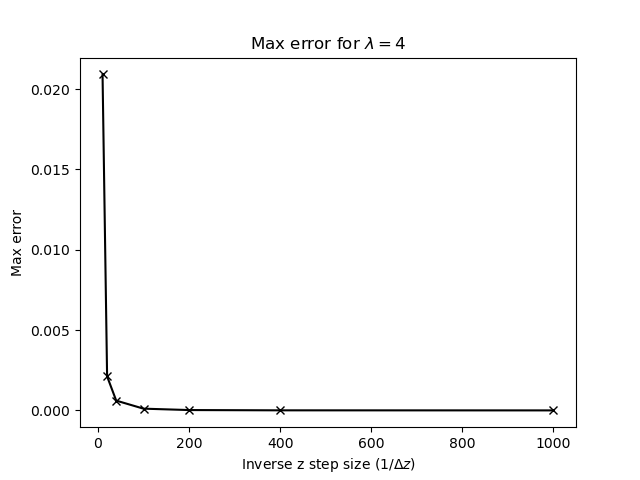

In [87]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 4$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.plot(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

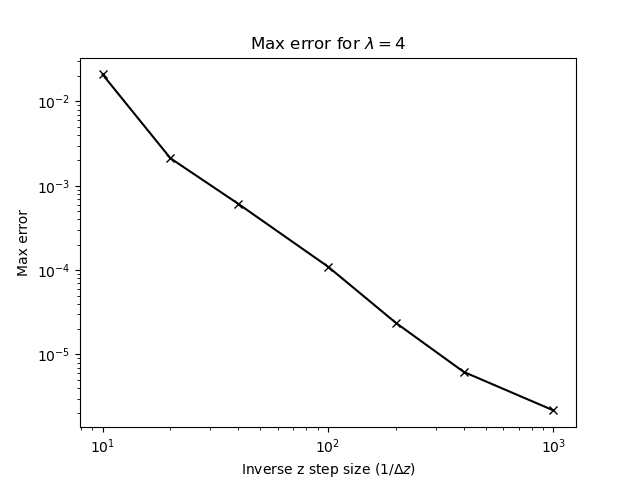

In [88]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 4$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.loglog(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

### 5. $\lambda = \frac{\Delta t}{\Delta z} = 3$

In [89]:
# Empty list to store max error values
L5_max_errors = []
L5_real_max_errors = []
# Empty list to store dt and dz's
L5_dt_vals = []
L5_dz_vals = []


#### 5.1 Parameters $\Delta z = 0.1, \Delta t = 0.3$

In [90]:
dZ=0.1
dt=0.3

In [91]:
L5P1 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.10013855831631045 and dt = 0.2857142857142857
lambda = 2.8531895257747975

 Tridiagonal system coefficients:
lower diag values = -0.1540284915403157
diag values = 1.323396830113039
upper diag values = -0.1665111957155804

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 360.1741925741099 

located at 290, z value of 6.014330981789573, S value of 409.2519503012083 

2. Absolute sum of errors: 1212.0236183766972

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.01909853362407654 

located at 253, z value of 2.309204324086089, S value of 10.066411866183358 

2. Absolute sum of errors: 0.10902039945718445


In [92]:
L5_max_errors.append(L5P1[0])
L5_real_max_errors.append(L5P1[1])
L5_dt_vals.append(dt)
L5_dz_vals.append(dZ)

#### 5.2 Parameters $\Delta z = 0.05, \Delta t = 0.15$

In [93]:
dZ=0.05
dt=0.15

In [94]:
L5P2 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.049983690646773764 and dt = 0.15384615384615385
lambda = 3.0779270569145933

 Tridiagonal system coefficients:
lower diag values = -0.33964681306905264
diag values = 1.694298018550568
upper diag values = -0.35311274394305403

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 187.6433181738371 

located at 581, z value of 6.0146733358350986, S value of 409.39208334822206 

2. Absolute sum of errors: 1315.4513118615725

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.001915936006351579 

located at 500, z value of 1.965994393446426, S value of 7.142011029214633 

2. Absolute sum of errors: 0.04137655427904727


In [95]:
L5_max_errors.append(L5P2[0])
L5_real_max_errors.append(L5P2[1])
L5_dt_vals.append(dt)
L5_dz_vals.append(dZ)

#### 5.3 Parameters $\Delta z = 0.025, \Delta t = 0.075$

In [96]:
dZ = 0.025
dt = 0.075

In [97]:
L5P3 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.024991845323386882 and dt = 0.07407407407407407
lambda = 2.9639297585103486

 Tridiagonal system coefficients:
lower diag values = -0.6606181992945463
diag values = 2.3349443320233165
upper diag values = -0.6735853919880292

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 89.36044241757372 

located at 1162, z value of 6.0146733358350986, S value of 409.39208334822206 

2. Absolute sum of errors: 1288.8067908446894

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0005610089172292665 

located at 1001, z value of 1.9909862387698105, S value of 7.322752184286526 

2. Absolute sum of errors: 0.02124840762289956


In [98]:
L5_max_errors.append(L5P3[0])
L5_real_max_errors.append(L5P3[1])
L5_dt_vals.append(dt)
L5_dz_vals.append(dZ)

#### 5.4 Parameters $\Delta z = 0.01, \Delta t = 0.03$

In [99]:
dZ=0.01
dt=0.03

In [100]:
L5P4 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.010000156986444134 and dt = 0.029850746268656716
lambda = 2.9850277659762092

 Tridiagonal system coefficients:
lower diag values = -1.6725220112870203
diag values = 4.358402026512874
upper diag values = -1.6855815077631662

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 37.52828993018068 

located at 2904, z value of 6.014604958693308, S value of 409.364091244712 

2. Absolute sum of errors: 1391.357769891705

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 9.476045465817151e-05 

located at 2535, z value of 2.324547030695424, S value of 10.222048762627221 

2. Absolute sum of errors: 0.008918189779357998


In [101]:
L5_max_errors.append(L5P4[0])
L5_real_max_errors.append(L5P4[1])
L5_dt_vals.append(dt)
L5_dz_vals.append(dZ)

#### 5.5 Parameters: $\Delta z = 0.005, \Delta t = 0.015$

In [102]:
dZ=0.005
dt=0.015

In [103]:
L5P5 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.005000078493222067 and dt = 0.015037593984962405
lambda = 3.007471583765504

 Tridiagonal system coefficients:
lower diag values = -3.376773573600174
diag values = 7.7668552113191724
upper diag values = -3.3899312617791484

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 20.624898192272497 

located at 5810, z value of 6.024605115679751, S value of 413.4783336704678 

2. Absolute sum of errors: 1568.5093027250105

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 2.17285868368694e-05 

located at 5003, z value of 1.9895417716495452, S value of 7.312182345256763 

2. Absolute sum of errors: 0.004233058775821603


In [104]:
L5_max_errors.append(L5P5[0])
L5_real_max_errors.append(L5P5[1])
L5_dt_vals.append(dt)
L5_dz_vals.append(dZ)

#### 5.6 Parameters: $\Delta z = 0.0025, \Delta t = 0.0075$

In [105]:
dZ=0.0025
dt=0.0075

In [106]:
L5P6 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.0025000392466110336 and dt = 0.00749063670411985
lambda = 2.9962076452495285

 Tridiagonal system coefficients:
lower diag values = -6.734807167352421
diag values = 14.48279764951985
upper diag values = -6.747915575800388

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 12.421124924883998 

located at 11636, z value of 6.064605743625531, S value of 430.3529748175878 

2. Absolute sum of errors: 1904.6909942244977

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 5.271110437465865e-06 

located at 10139, z value of 2.3220469914488113, S value of 10.196525157840666 

2. Absolute sum of errors: 0.00218287334441453


In [107]:
L5_max_errors.append(L5P6[0])
L5_real_max_errors.append(L5P6[1])
L5_dt_vals.append(dt)
L5_dz_vals.append(dZ)

#### 5.7 Parameters: $\Delta z = 0.001, \Delta t = 0.003$

In [108]:
dZ=0.001
dt=0.003

In [109]:
L5P7 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.0010000156986444135 and dt = 0.0029985007496251873
lambda = 2.9984536779671065

 Tridiagonal system coefficients:
lower diag values = -16.859478047224307
diag values = 34.73210431429722
upper diag values = -16.872596282065416

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 9.607894391523416 

located at 29240, z value of 6.214608098422193, S value of 500.00000000000074 

2. Absolute sum of errors: 2931.853067516466

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 2.0242198344178064e-06 

located at 25337, z value of 2.31154682661305, S value of 10.090020101797625 

2. Absolute sum of errors: 0.0012151982663717584


In [110]:
L5_max_errors.append(L5P7[0])
L5_real_max_errors.append(L5P7[1])
L5_dt_vals.append(dt)
L5_dz_vals.append(dZ)

#### Additional dz

In [111]:
# Empty list to store max error values
L5a_max_errors = []
L5a_real_max_errors = []
# Empty list to store dt and dz's
L5a_dt_vals = []
L5a_dz_vals = []

In [112]:
# dZ = 0.075
# dt = 0.075*3

# L5a1 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L5a_max_errors.append(L5a1[0])
# L5a_real_max_errors.append(L5a1[1])
# L5a_dt_vals.append(dt)
# L5a_dz_vals.append(dZ)

# ###########

# dZ = 0.0375
# dt = 0.0375*3

# L5a2 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L5a_max_errors.append(L5a2[0])
# L5a_real_max_errors.append(L5a2[1])
# L5a_dt_vals.append(dt)
# L5a_dz_vals.append(dZ)

# ###########

# dZ = 0.0175
# dt = 0.0175*3

# L5a3 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L5a_max_errors.append(L5a3[0])
# L5a_real_max_errors.append(L5a3[1])
# L5a_dt_vals.append(dt)
# L5a_dz_vals.append(dZ)

# ###########

# dZ = 0.0075
# dt = 0.0075*3

# L5a4 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L5a_max_errors.append(L5a4[0])
# L5a_real_max_errors.append(L5a4[1])
# L5a_dt_vals.append(dt)
# L5a_dz_vals.append(dZ)

# ###########

# dZ = 0.00375
# dt = 0.00375*3

# L5a5 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L5a_max_errors.append(L5a5[0])
# L5a_real_max_errors.append(L5a5[1])
# L5a_dt_vals.append(dt)
# L5a_dz_vals.append(dZ)

# ###########

# dZ = 0.00175
# dt = 0.00175*3

# L5a6 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L5a_max_errors.append(L5a6[0])
# L5a_real_max_errors.append(L5a6[1])
# L5a_dt_vals.append(dt)
# L5a_dz_vals.append(dZ)

# ###########

# dZ = 0.00075
# dt = 0.00075*3

# L5a7 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L5a_max_errors.append(L5a7[0])
# L5a_real_max_errors.append(L5a7[1])
# L5a_dt_vals.append(dt)
# L5a_dz_vals.append(dZ)

# ###########

# dZ = 0.0005
# dt = 0.0005*3

# L5a8 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L5a_max_errors.append(L5a8[0])
# L5a_real_max_errors.append(L5a8[1])
# L5a_dt_vals.append(dt)
# L5a_dz_vals.append(dZ)

# ###########

# dZ = 0.00025
# dt = 0.00025*3

# L5a9 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L5a_max_errors.append(L5a9[0])
# L5a_real_max_errors.append(L5a9[1])
# L5a_dt_vals.append(dt)
# L5a_dz_vals.append(dZ)

#### PLOTS of Convergence for decreasing step size

In [113]:
# delta t values
dt_vals = np.array(L5_dt_vals + L5a_dt_vals)
sorted_indices = np.argsort(dt_vals)
dt_vals = np.array([dt_vals[i] for i in sorted_indices])
inv_dt_vals = np.divide(np.ones(len(dt_vals)), dt_vals)

# delta z values
dz_vals = np.array(L5_dz_vals + L5a_dz_vals)
dz_vals = np.array([dz_vals[i] for i in sorted_indices])
inv_dz_vals = np.divide(np.ones(len(dz_vals)), dz_vals)


# max errors in realistic range
real_max_errors = np.array(L5_real_max_errors + L5a_real_max_errors)
real_max_errors = np.array([real_max_errors[i] for i in sorted_indices])

# max errors in entire range
max_errors = np.array(L5_max_errors + L5a_max_errors)
max_errors = np.array([max_errors[i] for i in sorted_indices])

##### Realistic S domain for 1/dz

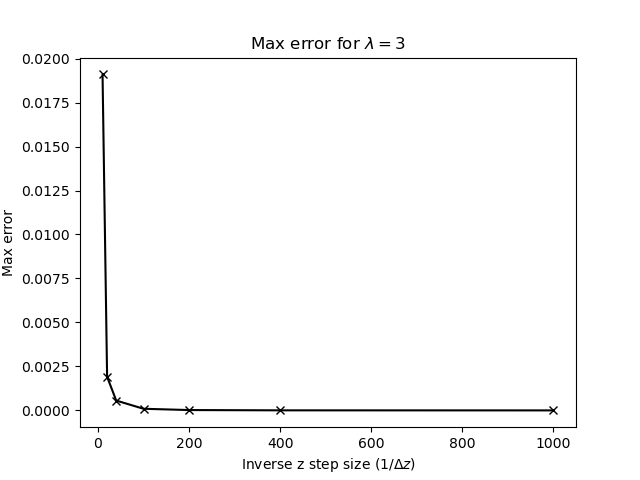

In [114]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 3$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.plot(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

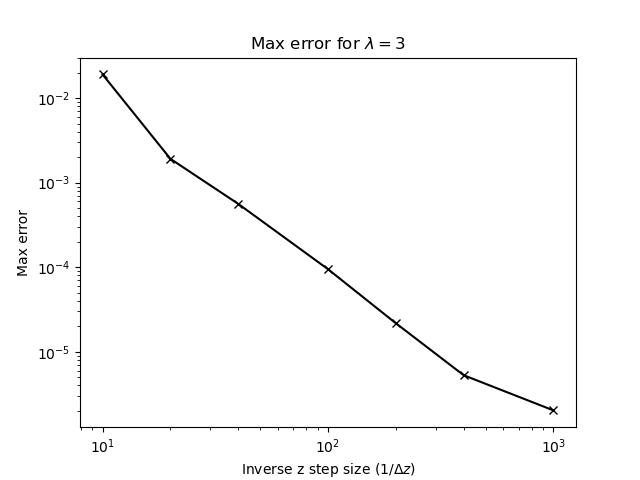

In [115]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 3$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.loglog(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

### 6. $\lambda = \frac{\Delta t}{\Delta z} = 6$

In [154]:
# Empty list to store max error values
L6_max_errors = []
L6_real_max_errors = []
# Empty list to store dt and dz's
L6_dt_vals = []
L6_dz_vals = []

#### 6.1 Parameters $\Delta z = 0.1, \Delta t = 0.6$

In [155]:
dZ=0.1
dt=0.3*2

In [156]:
L6P1 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.10013855831631045 and dt = 0.6666666666666666
lambda = 6.65744222680786

 Tridiagonal system coefficients:
lower diag values = -0.35939981359407
diag values = 1.754592603597091
upper diag values = -0.3885261233363543

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 1105.0963199189764 

located at 290, z value of 6.014330981789573, S value of 409.2519503012083 

2. Absolute sum of errors: 3085.8275979955833

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.02746669331409568 

located at 253, z value of 2.309204324086089, S value of 10.066411866183358 

2. Absolute sum of errors: 0.14128590306886157


In [157]:
L6_max_errors.append(L6P1[0])
L6_real_max_errors.append(L6P1[1])
L6_dt_vals.append(dt)
L6_dz_vals.append(dZ)

#### 6.2 Parameters $\Delta z = 0.05, \Delta t = 0.3$

In [158]:
dZ=0.05
dt=0.15*2

In [159]:
L6P2 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.049983690646773764 and dt = 0.2857142857142857
lambda = 5.716150248555673

 Tridiagonal system coefficients:
lower diag values = -0.6307726528425263
diag values = 2.2894106058796266
upper diag values = -0.6557808101799574

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 369.3977927031832 

located at 581, z value of 6.0146733358350986, S value of 409.39208334822206 

2. Absolute sum of errors: 2478.280636393876

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.002866818782947922 

located at 507, z value of 2.3158802279738424, S value of 10.133839082682153 

2. Absolute sum of errors: 0.05087564902842106


In [160]:
L6_max_errors.append(L6P2[0])
L6_real_max_errors.append(L6P2[1])
L6_dt_vals.append(dt)
L6_dz_vals.append(dZ)

#### 6.3 Parameters $\Delta z = 0.025, \Delta t = 0.15$

In [161]:
dZ = 0.025
dt = 0.075*2

In [162]:
L6P3 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.024991845323386882 and dt = 0.15384615384615385
lambda = 6.155854113829187

 Tridiagonal system coefficients:
lower diag values = -1.3720531831502119
diag values = 3.7725766895868884
upper diag values = -1.3989850448982146

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 188.32378548125655 

located at 1162, z value of 6.0146733358350986, S value of 409.39208334822206 

2. Absolute sum of errors: 2637.680227458479

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0007774966141292361 

located at 1000, z value of 1.965994393446426, S value of 7.142011029214633 

2. Absolute sum of errors: 0.025120118639080747


In [163]:
L6_max_errors.append(L6P3[0])
L6_real_max_errors.append(L6P3[1])
L6_dt_vals.append(dt)
L6_dz_vals.append(dZ)

#### 6.4 Parameters $\Delta z = 0.01, \Delta t = 0.06$

In [164]:
dZ=0.01
dt=0.03*2

In [165]:
L6P4 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.010000156986444134 and dt = 0.06060606060606061
lambda = 6.0605109188001824

 Tridiagonal system coefficients:
lower diag values = -3.3957265077645564
diag values = 7.818573811404924
upper diag values = -3.422241243034307

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 73.60322956165174 

located at 2903, z value of 6.004604801706865, S value of 405.2907868545423 

2. Absolute sum of errors: 2657.4702361454515

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.00015462800975529767 

located at 2535, z value of 2.324547030695424, S value of 10.222048762627221 

2. Absolute sum of errors: 0.011281936559630999


In [166]:
L6_max_errors.append(L6P4[0])
L6_real_max_errors.append(L6P4[1])
L6_dt_vals.append(dt)
L6_dz_vals.append(dZ)

#### 6.5 Parameters: $\Delta z = 0.005, \Delta t = 0.03$

In [167]:
dZ=0.005
dt=0.015*2

In [168]:
L6P5 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.005000078493222067 and dt = 0.029850746268656716
lambda = 5.9700555319524184

 Tridiagonal system coefficients:
lower diag values = -6.703147541624226
diag values = 14.432712583663431
upper diag values = -6.729266534576519

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 37.54682568587202 

located at 5807, z value of 6.0096048802000865, S value of 407.3223473498158 

2. Absolute sum of errors: 2777.901891078601

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 2.9752190127033118e-05 

located at 4997, z value of 1.959541300690212, S value of 7.0960713554848605 

2. Absolute sum of errors: 0.005029892330366208


In [169]:
L6_max_errors.append(L6P5[0])
L6_real_max_errors.append(L6P5[1])
L6_dt_vals.append(dt)
L6_dz_vals.append(dZ)

#### 6.6 Parameters: $\Delta z = 0.0025, \Delta t = 0.015$

In [170]:
dZ=0.0025
dt=0.0075*2

In [171]:
L6P6 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.0025000392466110336 and dt = 0.015037593984962405
lambda = 6.014943167531008

 Tridiagonal system coefficients:
lower diag values = -13.520251982579671
diag values = 28.06696971745714
upper diag values = -13.546567358937619

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 20.625321486019914 

located at 11621, z value of 6.027105154926364, S value of 414.5133389701206 

2. Absolute sum of errors: 3131.9082561757546

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 8.927015027193619e-06 

located at 10140, z value of 2.324547030695424, S value of 10.222048762627221 

2. Absolute sum of errors: 0.002750384097862465


In [172]:
L6_max_errors.append(L6P6[0])
L6_real_max_errors.append(L6P6[1])
L6_dt_vals.append(dt)
L6_dz_vals.append(dZ)

#### 6.7 Parameters: $\Delta z = 0.001, \Delta t = 0.006$

In [173]:
dZ=0.001
dt=0.003*2

In [174]:
L6P7 = PV_Rannacher(dt=dt, dZ=dZ, R=2)

Stepsizes: dz = 0.0010000156986444135 and dt = 0.006006006006006006
lambda = 6.005911721333514

 Tridiagonal system coefficients:
lower diag values = -33.769585157653495
diag values = 68.5655062391479
upper diag values = -33.795861021434334

 ENTIRE S DOMAIN ERRORS
1. Maximal error: 11.098954139543366 

located at 29238, z value of 6.212608067024906, S value of 499.0009836663898 

2. Absolute sum of errors: 4151.46126003502

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 2.603174270809916e-06 

located at 25342, z value of 2.3165469051062715, S value of 10.140597333997784 

2. Absolute sum of errors: 0.001437554259934625


In [175]:
L6_max_errors.append(L6P7[0])
L6_real_max_errors.append(L6P7[1])
L6_dt_vals.append(dt)
L6_dz_vals.append(dZ)

#### Additional dz

In [176]:
# Empty list to store max error values
L6a_max_errors = []
L6a_real_max_errors = []
# Empty list to store dt and dz's
L6a_dt_vals = []
L6a_dz_vals = []

In [139]:
# dZ = 0.075
# dt = 0.075*3*2

# L6a1 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L6a_max_errors.append(L6a1[0])
# L6a_real_max_errors.append(L6a1[1])
# L6a_dt_vals.append(dt)
# L6a_dz_vals.append(dZ)

# ###########

# dZ = 0.0375
# dt = 0.0375*3*2

# L6a2 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L6a_max_errors.append(L6a2[0])
# L6a_real_max_errors.append(L6a2[1])
# L6a_dt_vals.append(dt)
# L6a_dz_vals.append(dZ)

# ###########

# dZ = 0.0175
# dt = 0.0175*3*2

# L6a3 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L6a_max_errors.append(L6a3[0])
# L6a_real_max_errors.append(L6a3[1])
# L6a_dt_vals.append(dt)
# L6a_dz_vals.append(dZ)

# ###########

# dZ = 0.0075
# dt = 0.0075*3*2

# L6a4 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L6a_max_errors.append(L6a4[0])
# L6a_real_max_errors.append(L6a4[1])
# L6a_dt_vals.append(dt)
# L6a_dz_vals.append(dZ)

# ###########

# dZ = 0.00375
# dt = 0.00375*3*2

# L6a5 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L6a_max_errors.append(L6a5[0])
# L6a_real_max_errors.append(L6a5[1])
# L6a_dt_vals.append(dt)
# L6a_dz_vals.append(dZ)

# ###########

# dZ = 0.00175
# dt = 0.00175*3*2

# L6a6 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L6a_max_errors.append(L6a6[0])
# L6a_real_max_errors.append(L6a6[1])
# L6a_dt_vals.append(dt)
# L6a_dz_vals.append(dZ)

# ###########

# dZ = 0.00075
# dt = 0.00075*3*2

# L6a7 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L6a_max_errors.append(L6a7[0])
# L6a_real_max_errors.append(L6a7[1])
# L6a_dt_vals.append(dt)
# L6a_dz_vals.append(dZ)

# ###########

# dZ = 0.0005
# dt = 0.0005*3*2

# L6a8 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L6a_max_errors.append(L6a8[0])
# L6a_real_max_errors.append(L6a8[1])
# L6a_dt_vals.append(dt)
# L6a_dz_vals.append(dZ)

# ###########

# dZ = 0.00025
# dt = 0.00025*3*2

# L6a9 = PV_Rannacher(dt=dt, dZ=dZ, R=2)
# L6a_max_errors.append(L6a9[0])
# L6a_real_max_errors.append(L6a9[1])
# L6a_dt_vals.append(dt)
# L6a_dz_vals.append(dZ)

#### PLOTS of Convergence for decreasing step size

In [177]:
# delta t values
dt_vals = np.array(L6_dt_vals + L6a_dt_vals)
sorted_indices = np.argsort(dt_vals)
dt_vals = np.array([dt_vals[i] for i in sorted_indices])
inv_dt_vals = np.divide(np.ones(len(dt_vals)), dt_vals)

# delta z values
dz_vals = np.array(L6_dz_vals + L6a_dz_vals)
dz_vals = np.array([dz_vals[i] for i in sorted_indices])
inv_dz_vals = np.divide(np.ones(len(dz_vals)), dz_vals)


# max errors in realistic range
real_max_errors = np.array(L6_real_max_errors + L6a_real_max_errors)
real_max_errors = np.array([real_max_errors[i] for i in sorted_indices])

# max errors in entire range
max_errors = np.array(L6_max_errors + L6a_max_errors)
max_errors = np.array([max_errors[i] for i in sorted_indices])

##### Realistic S domain for 1/dz

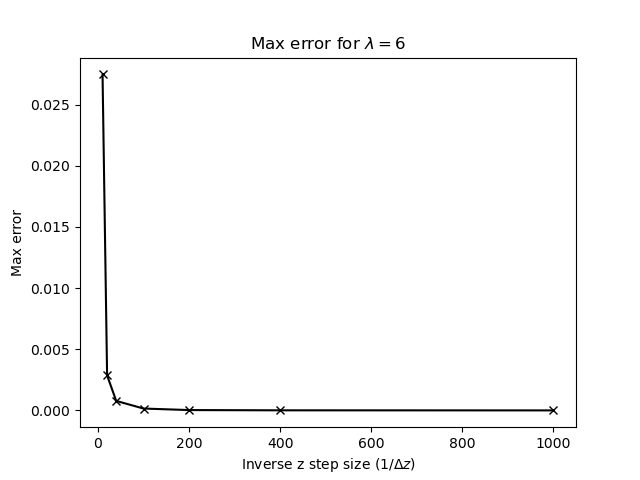

In [178]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 6$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.plot(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

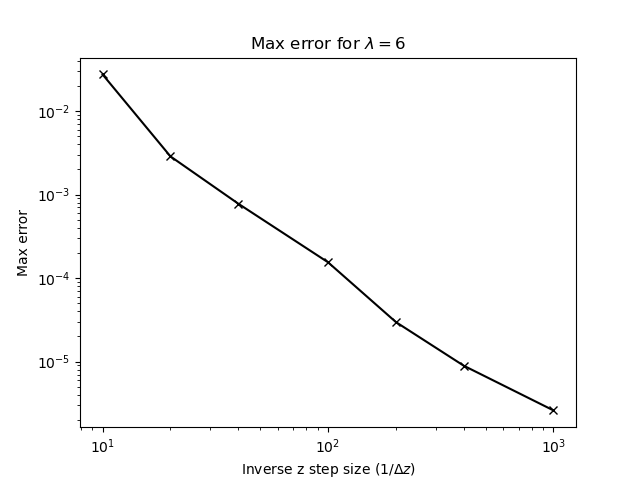

In [179]:
inv_z = np.linspace(0, max(inv_dz_vals), 1000)
plt.figure()
plt.title('Max error for $\\lambda = 6$')
plt.ylabel('Max error')
plt.xlabel('Inverse z step size $(1 / \Delta z)$')
plt.xlim
plt.loglog(inv_dz_vals, real_max_errors, marker='x', color='black', label='Max error/step size data points')
plt.show()

## NEXT CELLS

### Storing data

In [186]:
# write a pandas dataframe with all the values so that they do not need to be recalculated
import pandas as pd

ErrorVals2 = pd.DataFrame({'Real Errors': L2_real_max_errors + L2a_real_max_errors,
                           'dt': L2_dt_vals + L2a_dt_vals, 
                           'dz': L2_dz_vals + L2a_dz_vals,
                           'lambda': np.divide(np.array(L2_dt_vals + L2a_dt_vals), 
                                               np.array(L2_dz_vals + L2a_dz_vals)),
                           'Entire Errors': L2_max_errors + L2a_max_errors,
                         })

print(ErrorVals2)

# write to csv file
ErrorVals2.to_csv('RCN2 l10 data.csv', index=False)

### --------------------------------------------

ErrorVals3 = pd.DataFrame({'Real Errors': L3_real_max_errors + L3a_real_max_errors,
                           'dt': L3_dt_vals + L3a_dt_vals, 
                           'dz': L3_dz_vals + L3a_dz_vals,
                           'lambda': np.divide(np.array(L3_dt_vals + L3a_dt_vals), 
                                               np.array(L3_dz_vals + L3a_dz_vals)),
                           'Entire Errors': L3_max_errors + L3a_max_errors,
                         })

print(ErrorVals3)

# write to csv file
ErrorVals3.to_csv('RCN2 l5 data.csv', index=False)

### --------------------------------------------

ErrorVals4 = pd.DataFrame({'Real Errors': L4_real_max_errors + L4a_real_max_errors,
                           'dt': L4_dt_vals + L4a_dt_vals, 
                           'dz': L4_dz_vals + L4a_dz_vals,
                           'lambda': np.divide(np.array(L4_dt_vals + L4a_dt_vals), 
                                               np.array(L4_dz_vals + L4a_dz_vals)),
                           'Entire Errors': L4_max_errors + L4a_max_errors,
                         })

print(ErrorVals4)

# write to csv file
ErrorVals4.to_csv('RCN2 l4 data.csv', index=False)

### --------------------------------------------

ErrorVals5 = pd.DataFrame({'Real Errors': L5_real_max_errors + L5a_real_max_errors,
                           'dt': L5_dt_vals + L5a_dt_vals, 
                           'dz': L5_dz_vals + L5a_dz_vals,
                           'lambda': np.divide(np.array(L5_dt_vals + L5a_dt_vals), 
                                               np.array(L5_dz_vals + L5a_dz_vals)),
                           'Entire Errors': L5_max_errors + L5a_max_errors,
                         })

print(ErrorVals5)

# write to csv file
ErrorVals5.to_csv('RCN2 l3 data.csv', index=False)

### ---------------------------------------------

ErrorVals6 = pd.DataFrame({'Real Errors': L6_real_max_errors + L6a_real_max_errors,
                           'dt': L6_dt_vals + L6a_dt_vals, 
                           'dz': L6_dz_vals + L6a_dz_vals,
                           'lambda': np.divide(np.array(L6_dt_vals + L6a_dt_vals), 
                                               np.array(L6_dz_vals + L6a_dz_vals)),
                           'Entire Errors': L6_max_errors + L6a_max_errors,
                         })

print(ErrorVals6)

# write to csv file
ErrorVals6.to_csv('RCN2 l6 data.csv', index=False)

   Real Errors     dt      dz  lambda  Entire Errors
0     0.047598  1.000  0.1000    10.0    2793.639385
1     0.006734  0.500  0.0500    10.0     763.020142
2     0.001315  0.250  0.0250    10.0     317.462827
3     0.000291  0.100  0.0100    10.0     121.210131
4     0.000055  0.050  0.0050    10.0      94.407466
5     0.000018  0.025  0.0025    10.0      87.471407
6     0.000004  0.010  0.0010    10.0      83.987166
   Real Errors      dt      dz  lambda  Entire Errors
0     0.023060  0.5000  0.1000     5.0     706.093206
1     0.002451  0.2500  0.0500     5.0     316.734714
2     0.000677  0.1250  0.0250     5.0     151.671589
3     0.000129  0.0500  0.0100     5.0      61.055801
4     0.000026  0.0250  0.0050     5.0      31.957451
5     0.000007  0.0125  0.0025     5.0      17.795154
6     0.000002  0.0050  0.0010     5.0      10.139681
   Real Errors     dt      dz  lambda  Entire Errors
0     0.020917  0.400  0.1000     4.0     533.606324
1     0.002121  0.200  0.0500     4.0 

# All on one PLOT

In [180]:
# delta z values
dz_vals_l6 = np.array(L6_dz_vals + L6a_dz_vals)
sorted_indices = np.argsort(dz_vals_l6)
dz_vals_l6 = np.array([dz_vals_l6[i] for i in sorted_indices])
inv_dz_vals_l6 = np.divide(np.ones(len(dz_vals_l6)), dz_vals_l6)

# max errors in realistic range
real_max_errors_l6 = np.array(L6_real_max_errors + L6a_real_max_errors)
real_max_errors_l6 = np.array([real_max_errors_l6[i] for i in sorted_indices])

In [181]:
# delta z values
dz_vals_l10 = np.array(L2_dz_vals + L2a_dz_vals)
sorted_indices = np.argsort(dz_vals_l10)
dz_vals_l10 = np.array([dz_vals_l10[i] for i in sorted_indices])
inv_dz_vals_l10 = np.divide(np.ones(len(dz_vals_l10)), dz_vals_l10)

# max errors in realistic range
real_max_errors_l10 = np.array(L2_real_max_errors + L2a_real_max_errors)
real_max_errors_l10 = np.array([real_max_errors_l10[i] for i in sorted_indices])

In [182]:
# delta z values
dz_vals_l5 = np.array(L3_dz_vals + L3a_dz_vals)
sorted_indices = np.argsort(dz_vals_l5)
dz_vals_l5 = np.array([dz_vals_l5[i] for i in sorted_indices])
inv_dz_vals_l5 = np.divide(np.ones(len(dz_vals_l5)), dz_vals_l5)

# max errors in realistic range
real_max_errors_l5 = np.array(L3_real_max_errors + L3a_real_max_errors)
real_max_errors_l5 = np.array([real_max_errors_l5[i] for i in sorted_indices])

In [183]:
# delta z values
dz_vals_l4 = np.array(L4_dz_vals + L4a_dz_vals)
sorted_indices = np.argsort(dz_vals_l4)
dz_vals_l4 = np.array([dz_vals_l4[i] for i in sorted_indices])
inv_dz_vals_l4 = np.divide(np.ones(len(dz_vals_l4)), dz_vals_l4)

# max errors in realistic range
real_max_errors_l4 = np.array(L4_real_max_errors + L4a_real_max_errors)
real_max_errors_l4 = np.array([real_max_errors_l4[i] for i in sorted_indices])

In [184]:
# delta z values
dz_vals_l3 = np.array(L5_dz_vals + L5a_dz_vals)
sorted_indices = np.argsort(dz_vals_l3)
dz_vals_l3 = np.array([dz_vals_l3[i] for i in sorted_indices])
inv_dz_vals_l3 = np.divide(np.ones(len(dz_vals_l3)), dz_vals_l3)

# max errors in realistic range
real_max_errors_l3 = np.array(L5_real_max_errors + L5a_real_max_errors)
real_max_errors_l3 = np.array([real_max_errors_l3[i] for i in sorted_indices])

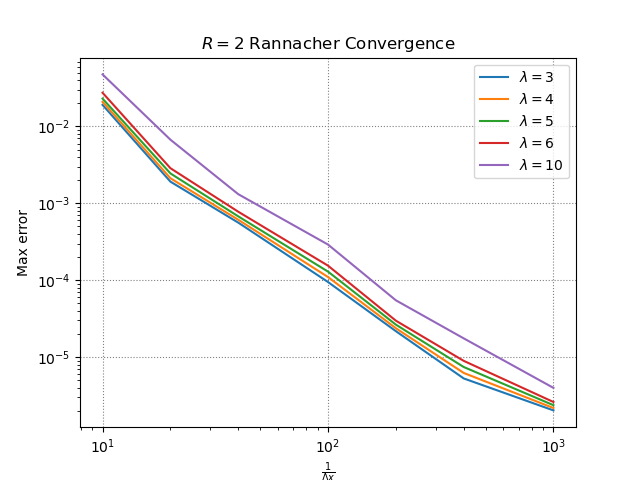

In [187]:
plt.figure()
plt.title('$R=2$ Rannacher Convergence')
plt.xlabel('$\\frac{1}{\\Delta x}$')
plt.ylabel('Max error')
plt.loglog(inv_dz_vals_l3, real_max_errors_l3, label='$\\lambda = 3$')
plt.loglog(inv_dz_vals_l4, real_max_errors_l4, label='$\\lambda = 4$')
plt.loglog(inv_dz_vals_l5, real_max_errors_l5, label='$\\lambda = 5$')
plt.loglog(inv_dz_vals_l6, real_max_errors_l6, label='$\\lambda = 6$')
plt.loglog(inv_dz_vals_l10, real_max_errors_l10, label='$\\lambda = 10$')
plt.legend()
plt.grid(True, linestyle='dotted', color='grey')
plt.show()
